In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio.PDB import *
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import subprocess

import esm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


torch.set_grad_enabled(False)

In [3]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)


def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)


def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)


def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]


def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts


# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]


def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics


parser = PDBParser(PERMISSIVE = True, QUIET = True) 
pdbl = PDBList() 


def get_pdb_residues(PDB_ID):
    pdb = PDB_ID.upper()[:4]
    chain_id = PDB_ID.upper()[-1]
    
    ## Get the data from the pdb file
    pdbl.retrieve_pdb_file(PDB_ID.upper()[:4], pdir = '.', file_format = 'pdb')
    data = parser.get_structure(pdb,"pdb" + pdb.lower() + ".ent")
    os.remove("pdb" + pdb.lower() + ".ent")

    all_residues = {}
    
    missing = [res for res in data.header["missing_residues"] if res["chain"] == chain_id]
    for res in missing:
        key = res["ssseq"]
        all_residues[key] = False
    
    model = list(data.get_models())[0]
    chains = list(model.get_chains()) 
    residues = list([chain for chain in chains if chain.id == chain_id][0].get_residues())
    residues = [res for res in residues if str(res)[17] == ' ']
    for res in residues:
        if not str(res)[28].isnumeric():
            key = int(str(res)[26:28])
        elif not str(res)[29].isnumeric():
            key = int(str(res)[26:29])
        else:
            key = int(str(res)[26:30])
        all_residues[key] = True
    
    pdb_indices = []
    index = 0
    for i in range(10000):
        if i in all_residues:
            if all_residues[i]:
                pdb_indices.append(index)
            index += 1
    return pdb_indices


"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])


def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()


def get_gpu_memory():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    gpu_memory = [int(x.split()[0]) for x in output.strip().split('\n')[1:]]
    return gpu_memory


def get_subset_results(subsets, pdb_indices_0, pdb_indices_1, contacts, REF_0, REF_1, num_seqs=128):
    msa_transformer_predictions = {}
    msa_transformer_results_0 = []
    msa_transformer_results_1 = []

    # pdb_indices_0 = get_pdb_residues(REF_0)
    # pdb_indices_1 = get_pdb_residues(REF_1)

    for name, inputs in enumerate(subsets + [read_msa(full_msa_path)]):
        torch.cuda.empty_cache()
        if len(inputs) > num_seqs:
            inputs = greedy_select(inputs, num_seqs=num_seqs)
        msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
        msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
        msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
        
        pdb_indices_0 = [i for i in pdb_indices_0 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][pdb_indices_0][:,pdb_indices_0]
        metrics = {"id": name, "reference":REF_0, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts[REF_0][:len(pdb_indices_0),:len(pdb_indices_0)]))
        msa_transformer_results_0.append(metrics)

        pdb_indices_1 = [i for i in pdb_indices_1 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][pdb_indices_1][:,pdb_indices_1]
        metrics = {"id": name, "reference":REF_1, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts[REF_1][:len(pdb_indices_1),:len(pdb_indices_1)]))
        msa_transformer_results_1.append(metrics)


    msa_transformer_results_0 = pd.DataFrame(msa_transformer_results_0)
    msa_transformer_results_1 = pd.DataFrame(msa_transformer_results_1)
    
    # Add a column for the number of sequences in the subset
    msa_transformer_results_0["num_seqs"] = [len(subsets[i]) for i in range(len(subsets))] + [num_seqs]
    msa_transformer_results_1["num_seqs"] = [len(subsets[i]) for i in range(len(subsets))] + [num_seqs]

    return msa_transformer_results_0, msa_transformer_results_1


def display_contact_results(results_0, results_1, title=None, color_by_seqs=True):
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    if title is not None:
        fig.suptitle(title)

    # Loop over the subplots and plot the data
    for i, metric in enumerate(["long_P@L", "long_P@L2", "long_P@L5", "medium_P@L", "short_P@L", "local_P@L"]):
        row = i // 3
        col = i % 3
        axs[row, col].set_xlabel(f"{metric} for {REF_0}")
        axs[row, col].set_ylabel(f"{metric} for {REF_1}")
        axs[row, col].set_title(f"{metric} for {REF_0} and {REF_1}")
        
        axs[row, col].set_xlim([0, 1])
        axs[row, col].set_ylim([0, 1])

        # Adjusted num_seqs to give a roof of 128
        adjusted_num_seqs = results_0["num_seqs"].apply(lambda x: min(x, 128))

        if color_by_seqs:
            # Color the points by the number of sequences in the subset
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10, c=adjusted_num_seqs[:-1], cmap='cool')
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='black', marker='s')
            # Add a color bar
            if col == 2:
                fig.colorbar(axs[row, col].collections[0], ax=axs[row, col])
        else:
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10)
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='red')

    fig.tight_layout()
    plt.show()



In [4]:
print("Previous device?", torch.cuda.current_device())

torch.cuda.set_device(1)

print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())

Previous device? 0
Is cuda available? True
Is cuDNN version: 8700
cuDNN enabled?  True
Device count? 2
Current device? 1


In [ ]:
print("hi")

: 

In [5]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [7]:
USE_AF_CLUSTER_MSAS = True

REF_0, REF_1 = "2qke_e", "5jyt_a"
#REF_0, REF_1 = "5uhq_a", "4qnc_a"

if USE_AF_CLUSTER_MSAS:
    pdb_indices_0 = [index - 4 for index in get_pdb_residues(REF_0)]
    pdb_indices_1 = [index - 4 for index in get_pdb_residues(REF_1)]
    msa_files = Path("../AFcluster/data_sep2022/00_KaiB/kaib_dbscan_msas/").glob("*.a3m")
else:
    pdb_indices_0 = get_pdb_residues(REF_0)
    pdb_indices_1 = get_pdb_residues(REF_1)
    msa_files = Path("../AFcluster/msa_clusters/" + REF_0).glob("*.a3m")

msa_files = [str(msa_file) for msa_file in msa_files if not 'U10' in str(msa_file)]
full_msa_path = glob.glob("../AFcluster/full_msas/" + REF_0 + "*.a3m")[0]
hh_msa_path = glob.glob("../data/alignments/aligned_" + REF_0 + "*.a3m")[0]
msa_files.append(full_msa_path)
#msa_files.append(hh_msa_path)

msas = {
    name: read_msa(name)
    for name in msa_files
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name[:4], "cif")))[0]
    for name in (REF_0, REF_1)
}

contacts = {
    name: contacts_from_pdb(structure, chain=name.upper()[-1]) 
    for name, structure in structures.items()
}


### Extracting column attentions with MSA Transformer

In [6]:
NUM_SUBSETS = 32

# Remove sequences with more than 25% gaps
inputs = read_msa(full_msa_path)
print(len(inputs))
for i in range(len(inputs)-1, 0, -1):
    gaps = inputs[i][1].count('-') / len(inputs[i][1])
    if gaps > 0.25:
        inputs.pop(i)
print(len(inputs))

# Subsample the MSA and divide into subsets
inputs = read_msa(full_msa_path)
greedy_inputs = greedy_select(inputs, num_seqs=NUM_SUBSETS*127+1)
subsets = [[greedy_inputs[0]] + greedy_inputs[i::NUM_SUBSETS] for i in range(1, NUM_SUBSETS+1)]

# Get the query sums for each subset
query_sums = []
for i in range(NUM_SUBSETS):
    print("Subset", i, "completed")
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([subsets[i]])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
    column_attentions = result['col_attentions']
    attention_maps = column_attentions[0, 0:12, 0:12, :, :, :].cpu().numpy()
    summed_maps = np.sum(attention_maps, axis=(0, 1))

    query_col = summed_maps[:, 0, :]
    query_row = summed_maps[:, :, 0]
    query_col = np.reshape(query_col, (query_col.shape[0], query_col.shape[1]))
    query_row = np.reshape(query_row, (query_row.shape[0], query_row.shape[1]))

    query_sum = query_col + query_row
    query_sums.append(query_sum)

# Combine the query sums into a single tensor
query_sums = np.array(query_sums)
all_query_sums = query_sums.transpose(1, 0, 2).reshape(query_sums.shape[1], -1)

all_query_sums = all_query_sums.transpose(1, 0)
print(all_query_sums.shape)

#results_0, results_1 = get_subset_results(subsets, num_seqs=128)
#display_contact_results(results_0, results_1)

8236
6339
Subset 0 completed
Subset 1 completed
Subset 2 completed
Subset 3 completed
Subset 4 completed
Subset 5 completed
Subset 6 completed
Subset 7 completed
Subset 8 completed
Subset 9 completed
Subset 10 completed
Subset 11 completed
Subset 12 completed
Subset 13 completed
Subset 14 completed
Subset 15 completed
Subset 16 completed
Subset 17 completed
Subset 18 completed
Subset 19 completed
Subset 20 completed
Subset 21 completed
Subset 22 completed
Subset 23 completed
Subset 24 completed
Subset 25 completed
Subset 26 completed
Subset 27 completed
Subset 28 completed
Subset 29 completed
Subset 30 completed
Subset 31 completed
(4096, 109)


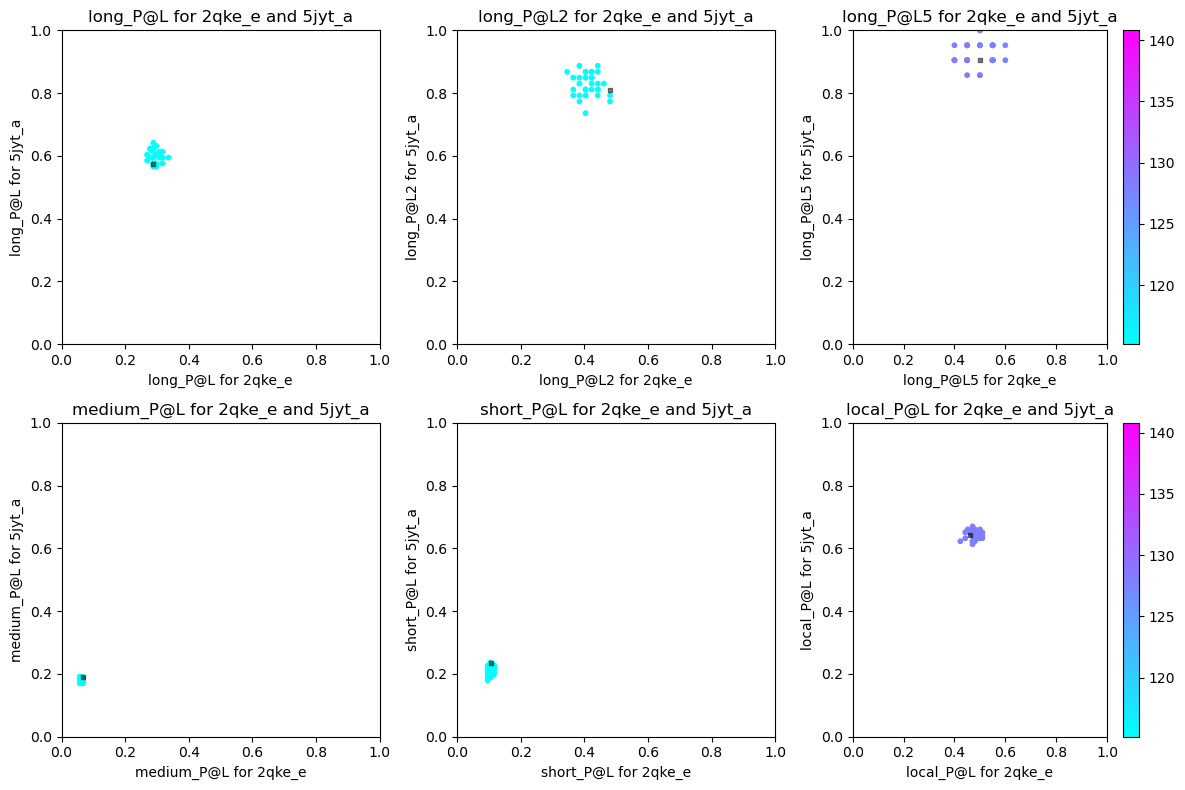

In [16]:
results_0, results_1 = get_subset_results(subsets=subsets, pdb_indices_0=pdb_indices_0, pdb_indices_1=pdb_indices_1, contacts=contacts, REF_0=REF_0, REF_1=REF_1, num_seqs=128)
display_contact_results(results_0, results_1)

In [35]:
NUM_SUBSETS = 32

# Remove sequences with more than 25% gaps
inputs = read_msa(full_msa_path)
print("Total n_seq:",len(inputs))
for i in range(len(inputs)-1, 0, -1):
    gaps = inputs[i][1].count('-') / len(inputs[i][1])
    if gaps > 0.25:
        inputs.pop(i)
print("n_seq with <= 0.25 gaps",len(inputs))


# Subsample the MSA and divide into subsets
inputs = read_msa(full_msa_path)
greedy_inputs = greedy_select(inputs, num_seqs=NUM_SUBSETS*127+1)
subsets = [[greedy_inputs[0]] + greedy_inputs[i::NUM_SUBSETS] for i in range(1, NUM_SUBSETS+1)]


# Get the query sums for each subset
query_sums = []
for i in range(NUM_SUBSETS):

    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([subsets[i]])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)

    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
    
    column_attentions = result['col_attentions']
    attention_maps = column_attentions[0, 0:12, 0:12, :, :, :].cpu().numpy()

    query_col = attention_maps[:, :, :, 0, :]
    query_row = attention_maps[:, :, :, :, 0]
    query_sum = query_row # + query_col
    query_sums.append(query_sum)
    print("Subset", i, "completed")


# Combine the query sums into a single tensor
query_sums = np.array(query_sums)
# Change the shape from (2, 12, 12, 109, 128) to (256, 12, 12, 109)
query_sums = query_sums.reshape(query_sums.shape[1] * query_sums.shape[2], query_sums.shape[0] * query_sums.shape[4], query_sums.shape[3])
print(query_sums.shape)

# Clear the GPU memory
torch.cuda.empty_cache()

Total n_seq: 8236
n_seq with <= 0.25 gaps 6339
Subset 0 completed
Subset 1 completed
Subset 2 completed
Subset 3 completed
Subset 4 completed
Subset 5 completed
Subset 6 completed
Subset 7 completed
Subset 8 completed
Subset 9 completed
Subset 10 completed
Subset 11 completed
Subset 12 completed
Subset 13 completed
Subset 14 completed
Subset 15 completed
Subset 16 completed
Subset 17 completed
Subset 18 completed
Subset 19 completed
Subset 20 completed
Subset 21 completed
Subset 22 completed
Subset 23 completed
Subset 24 completed
Subset 25 completed
Subset 26 completed
Subset 27 completed
Subset 28 completed
Subset 29 completed
Subset 30 completed
Subset 31 completed
(144, 4096, 109)


In [8]:

# Create a StandardScaler object
#scaler = StandardScaler()

# Normalize your data
#normalized_data = scaler.fit_transform(all_query_sums)

for i in np.arange(0.5, 20, 0.5):
    dbscan = DBSCAN(eps=i, min_samples=3)
    clusters = dbscan.fit_predict(all_query_sums)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    unclustered = np.count_nonzero(clusters == -1)
    print(f"eps = {round(i,2)}   Clusters: {n_clusters}    Unclustered: {unclustered}")
    if i>20 and n_clusters == 1:
        break



eps = 0.5   Clusters: 0    Unclustered: 4096
eps = 1.0   Clusters: 1    Unclustered: 4093
eps = 1.5   Clusters: 6    Unclustered: 4078
eps = 2.0   Clusters: 8    Unclustered: 4042
eps = 2.5   Clusters: 12    Unclustered: 3961
eps = 3.0   Clusters: 8    Unclustered: 3819
eps = 3.5   Clusters: 12    Unclustered: 3638
eps = 4.0   Clusters: 19    Unclustered: 3399
eps = 4.5   Clusters: 16    Unclustered: 3130
eps = 5.0   Clusters: 17    Unclustered: 2834
eps = 5.5   Clusters: 21    Unclustered: 2572
eps = 6.0   Clusters: 23    Unclustered: 2251
eps = 6.5   Clusters: 22    Unclustered: 1950
eps = 7.0   Clusters: 21    Unclustered: 1675
eps = 7.5   Clusters: 13    Unclustered: 1419
eps = 8.0   Clusters: 9    Unclustered: 1232
eps = 8.5   Clusters: 11    Unclustered: 1068
eps = 9.0   Clusters: 12    Unclustered: 912
eps = 9.5   Clusters: 7    Unclustered: 806
eps = 10.0   Clusters: 6    Unclustered: 695
eps = 10.5   Clusters: 5    Unclustered: 623
eps = 11.0   Clusters: 4    Unclustered: 560


In [75]:
best_eps_per_map = [[] for i in range(144)]
for map_index in range(144):
    n_clusters_list = []
    #unclustered_list = []
    eps_list = [0.1] #np.arange(0.02, 0.52, 0.02)
    for eps in eps_list:
        dbscan = DBSCAN(eps=eps, min_samples=3)
        clusters = dbscan.fit_predict(query_sums[map_index])
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_clusters_list.append(n_clusters)
        unclustered = np.count_nonzero(clusters == -1)
        #unclustered_list.append(unclustered)
        #print(f"eps = {round(i,2)}   Clusters: {n_clusters}    Unclustered: {unclustered}")
        if (eps>1 and n_clusters == 1) or unclustered == 0:
            break
    # Identify the epsilon value that gives the most clusters
    eps = round(eps_list[np.argmax(n_clusters_list)],2)
    n_clusters = np.max(n_clusters_list)
    #n_unclustered = unclustered_list[np.argmax(n_clusters_list)]
    print(f"Map index: {map_index}  Best eps: {round(eps, 3)}  Clusters: {n_clusters}")
    best_eps_per_map[map_index] = [round(eps, 3), np.max(n_clusters_list)]


Map index: 0  Best eps: 0.1  Clusters: 11
Map index: 1  Best eps: 0.1  Clusters: 13
Map index: 2  Best eps: 0.1  Clusters: 5
Map index: 3  Best eps: 0.1  Clusters: 24
Map index: 4  Best eps: 0.1  Clusters: 17
Map index: 5  Best eps: 0.1  Clusters: 17
Map index: 6  Best eps: 0.1  Clusters: 15
Map index: 7  Best eps: 0.1  Clusters: 16
Map index: 8  Best eps: 0.1  Clusters: 24
Map index: 9  Best eps: 0.1  Clusters: 8
Map index: 10  Best eps: 0.1  Clusters: 13
Map index: 11  Best eps: 0.1  Clusters: 8
Map index: 12  Best eps: 0.1  Clusters: 30
Map index: 13  Best eps: 0.1  Clusters: 14
Map index: 14  Best eps: 0.1  Clusters: 19
Map index: 15  Best eps: 0.1  Clusters: 6
Map index: 16  Best eps: 0.1  Clusters: 7
Map index: 17  Best eps: 0.1  Clusters: 27
Map index: 18  Best eps: 0.1  Clusters: 9
Map index: 19  Best eps: 0.1  Clusters: 13
Map index: 20  Best eps: 0.1  Clusters: 6
Map index: 21  Best eps: 0.1  Clusters: 19
Map index: 22  Best eps: 0.1  Clusters: 15
Map index: 23  Best eps: 0.1

In [84]:
best_eps = best_eps_per_map

# Create a dataframe with the best eps values
eps_df = pd.DataFrame(best_eps, columns=['eps', 'n_clusters'])

## Save the dataframe to a csv file
#eps_df.to_csv('../data/best_eps_5uhq_a.csv', index=False)

# Load the dataframe from a csv file
#eps_df = pd.read_csv('../data/best_eps.csv')

eps_df = eps_df.sort_values(by=['n_clusters'], ascending=False)

combined_clusters = []
all_subsets = [seq for subset in subsets for seq in subset]
for i in range(10):
    epsilon = eps_df.iloc[i]['eps']
    head_index = eps_df.index[i]

    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    clusters = dbscan.fit_predict(query_sums[head_index])
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    clustered_msa = [[] for i in range(n_clusters)]
    for i in range(len(clusters)):
        if clusters[i] != -1:
            clustered_msa[clusters[i]].append(all_subsets[i])
    combined_clusters += clustered_msa

print("Number of clusters:", len(combined_clusters))


Number of clusters: 268


In [85]:
combined_clusters = add_query_to_clusters(combined_clusters, full_msa_path)

In [73]:
dbscan = DBSCAN(eps=7, min_samples=3)
clusters = dbscan.fit_predict(all_query_sums)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters found: {n_clusters}")

all_subsets = [seq for subset in subsets for seq in subset]
clustered_msa = [[] for i in range(n_clusters)]
for i in range(len(clusters)):
    if clusters[i] != -1:
        clustered_msa[clusters[i]].append(all_subsets[i])


print("Number of sequences in each cluster:", [len(clustered_msa[i]) for i in range(n_clusters)])

Number of clusters found: 21
Number of sequences in each cluster: [2329, 4, 4, 9, 9, 3, 3, 3, 9, 3, 3, 4, 8, 3, 5, 5, 3, 5, 3, 3, 3]


In [79]:
def add_query_to_clusters(clusters, full_msa_path):
    query_seq = read_msa(full_msa_path)[0]
    for i in range(len(clusters)):
        clusters[i] = [query_seq] + clusters[i]
    return clusters

In [64]:
import random

# Randomize the order of the items in all_subsets
random_all_subsets = all_subsets.copy()
random.shuffle(random_all_subsets)
random_all_subsets = greedy_select(random_all_subsets, num_seqs=1028)
# Divide the first 500 sequences into 50 subsets
random_subsets = [random_all_subsets[i:i+10] for i in range(0, 500, 5)]
random_subsets = add_query_to_clusters(random_subsets, full_msa_path)

print(len(random_subsets), len(random_subsets[0]))

100 11


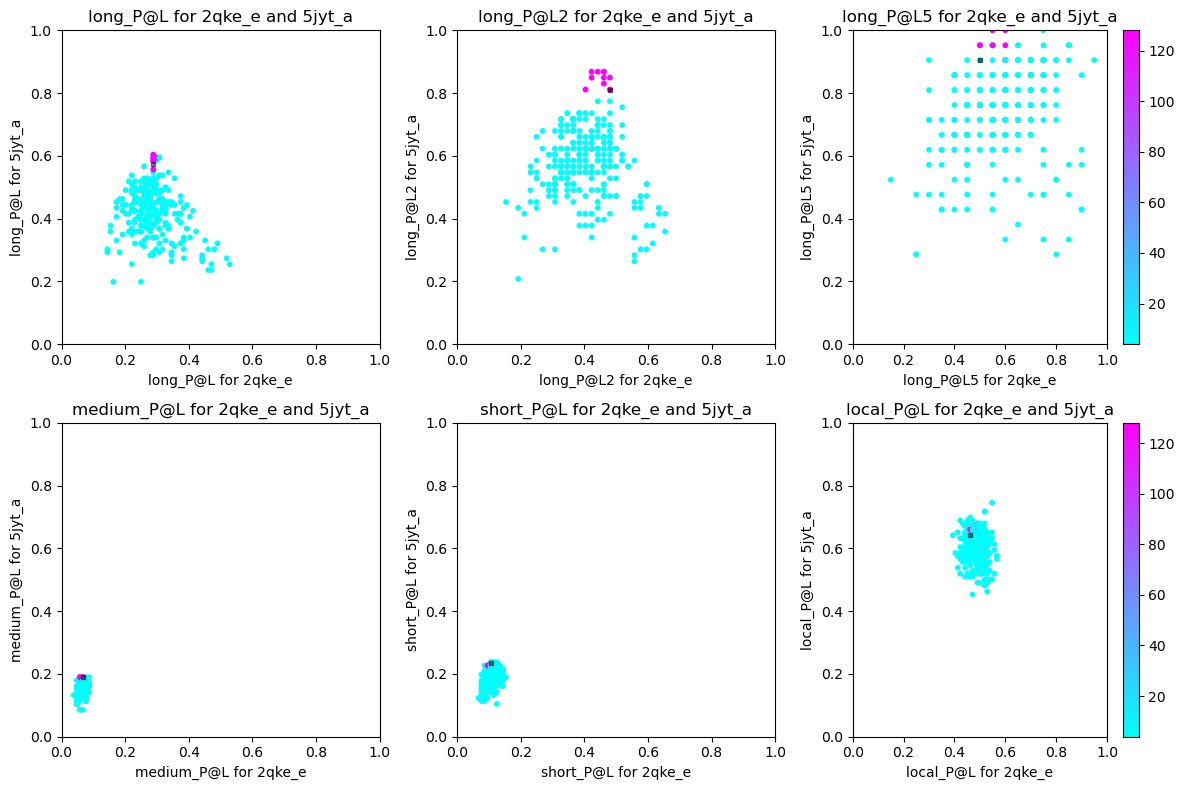

In [86]:
results_0, results_1 = get_subset_results(subsets=combined_clusters, num_seqs=128, pdb_indices_0=pdb_indices_0, pdb_indices_1=pdb_indices_1, contacts=contacts, REF_0=REF_0, REF_1=REF_1)
display_contact_results(results_0, results_1)


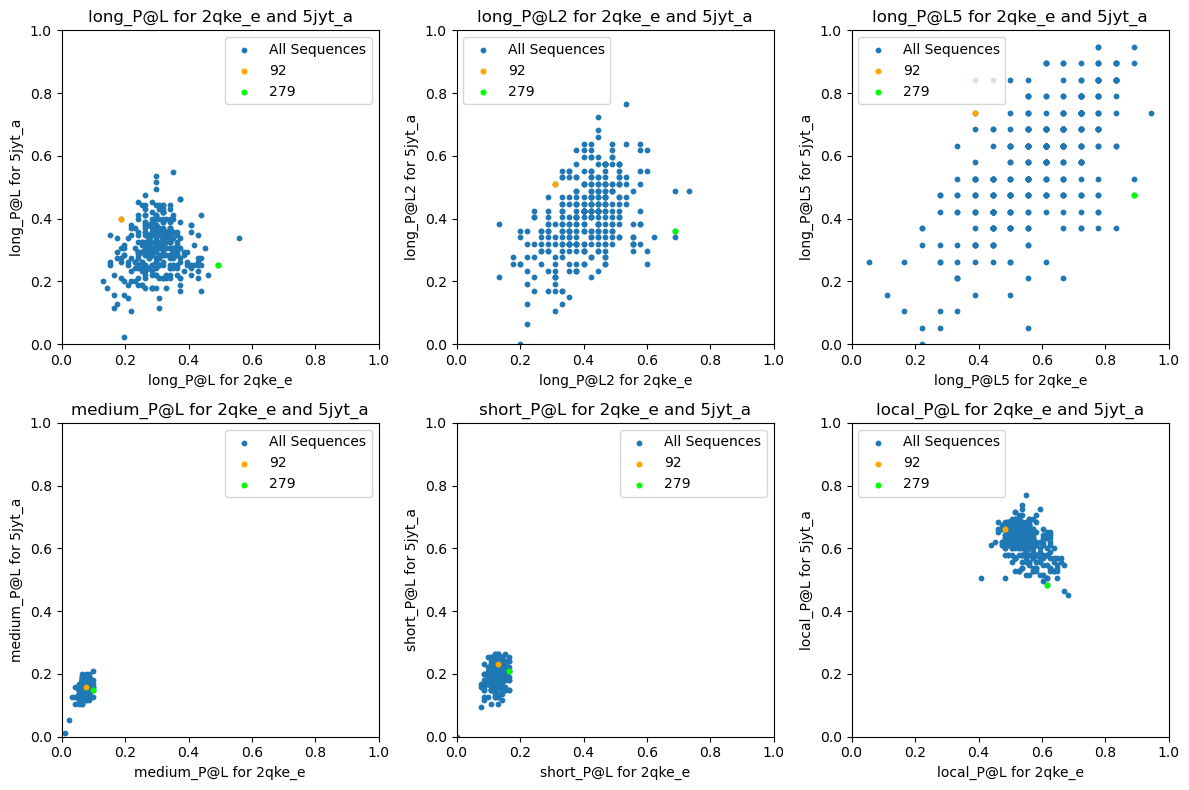

In [8]:
INDEX_LIST = ["92", "279"]

msas_list = []
for msa in msas:
    msas_list.append(msas[msa])

results_0, results_1 = get_subset_results(subsets=msas_list, num_seqs=128, pdb_indices_0=pdb_indices_0, pdb_indices_1=pdb_indices_1, contacts=contacts, REF_0=REF_0, REF_1=REF_1)
#display_contact_results(results_0, results_1, title="Clusters from AF-Cluster Repository", color_by_seqs=False)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Loop over the subplots and plot the data
for i, metric in enumerate(["long_P@L", "long_P@L2", "long_P@L5", "medium_P@L", "short_P@L", "local_P@L"]):
    row = i // 3
    col = i % 3
    axs[row, col].set_xlabel(f"{metric} for {REF_0}")
    axs[row, col].set_ylabel(f"{metric} for {REF_1}")
    axs[row, col].set_title(f"{metric} for {REF_0} and {REF_1}")
    
    axs[row, col].set_xlim([0, 1])
    axs[row, col].set_ylim([0, 1])

    # Adjusted num_seqs to give a roof of 128
    adjusted_num_seqs = results_0["num_seqs"].apply(lambda x: min(x, 128))
    
    axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10)

    colors = ["orange", "lime"]
    for index in INDEX_LIST:
        actual_index = [i for i, seq in enumerate(sequences) if "_" + index + ".a3m" in seq][0]
        axs[row, col].scatter(results_0[metric][actual_index], results_1[metric][actual_index], s=11, c= colors[INDEX_LIST.index(index)])
    #axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='red')

    # Add a legend
    axs[row, col].legend(["All Sequences"] + INDEX_LIST)


fig.tight_layout()
plt.show()


8236
6339
128


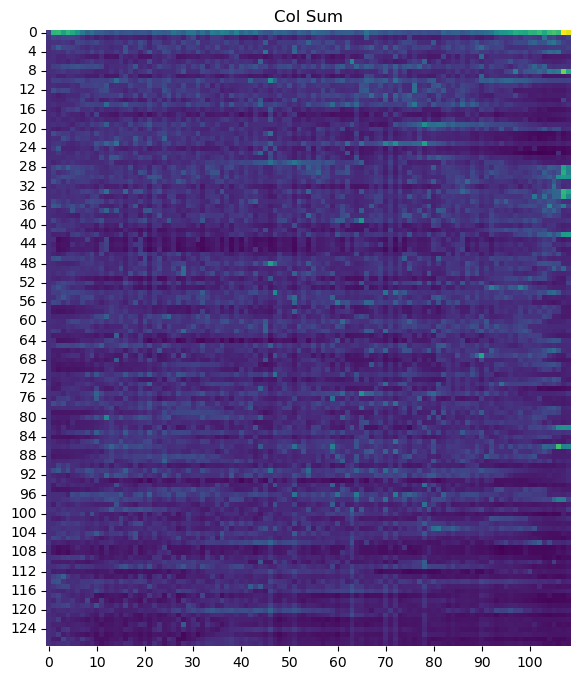

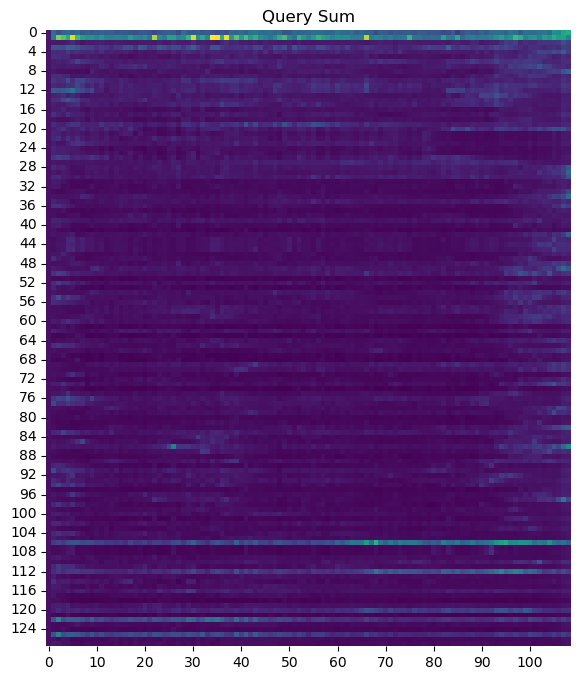

In [47]:
inputs = read_msa(full_msa_path)
print(len(inputs))
for i in range(len(inputs)-1, 0, -1):
    gaps = inputs[i][1].count('-') / len(inputs[i][1])
    if gaps > 0.25:
        inputs.pop(i)
print(len(inputs))

inputs = read_msa(full_msa_path)
greedy_select_inputs = greedy_select(inputs, num_seqs=128)
cluster_inputs = greedy_select(inputs, num_seqs=128)
print(len(cluster_inputs))
msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([cluster_inputs])
msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)

with torch.no_grad():
    result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
column_attentions = result['col_attentions']
attention_maps = column_attentions[0, 0:12, 0:12, :, :, :].cpu().numpy()
summed_maps = np.sum(attention_maps, axis=(0, 1))

col_sums = np.sum(summed_maps, axis=1)
col_sum_list = [col_sums[:, i] for i in range(col_sums.shape[1])]

query_col = summed_maps[:, 0, :]
query_row = summed_maps[:, :, 0]
query_col = np.reshape(query_col, (query_col.shape[0], query_col.shape[1]))
query_row = np.reshape(query_row, (query_row.shape[0], query_row.shape[1]))
query_sum = query_col + query_row
query_list = [query_sum[:, i] for i in range(query_sum.shape[1])]
query_col_list = [query_col[:, i] for i in range(query_col.shape[1])]
query_row_list = [query_row[:, i] for i in range(query_row.shape[1])]

cluster_dict = {"Col Sum": col_sum_list, "Query Sum": query_list}
# display_output_heatmap(np.transpose(col_sums), 'Col Sum')
# display_output_heatmap(np.transpose(query_sum), 'Query Sum')

0 ../AFcluster/msa_clusters/2qke_e/EX_072.a3m
Time taken: 0.0 seconds
50 ../AFcluster/msa_clusters/2qke_e/EX_026.a3m
Time taken: 7.64 seconds
100 ../AFcluster/msa_clusters/2qke_e/EX_042.a3m
Time taken: 9.48 seconds
150 ../AFcluster/msa_clusters/2qke_e/EX_078.a3m
Time taken: 11.12 seconds
200 ../AFcluster/msa_clusters/2qke_e/EX_039.a3m
Time taken: 12.45 seconds
250 ../AFcluster/msa_clusters/2qke_e/EX_099.a3m
Time taken: 13.75 seconds


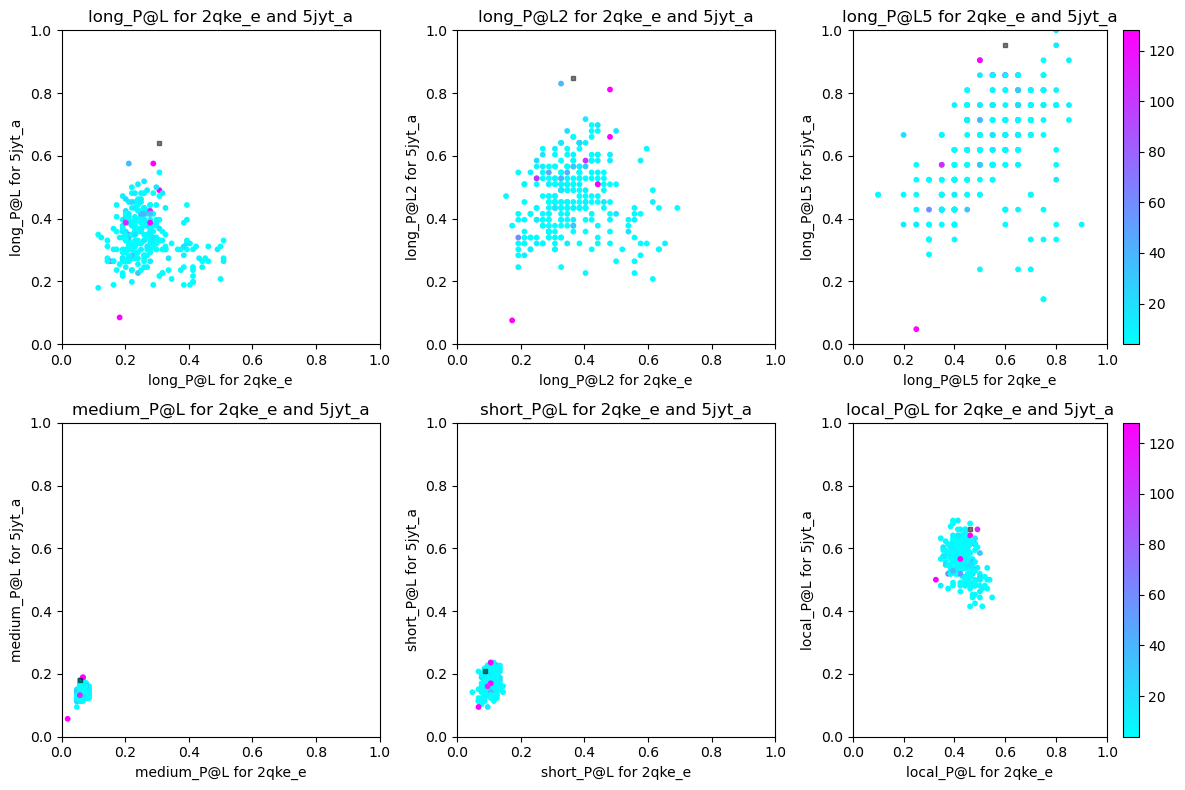

In [68]:
import time

NUM_SEQS = 128

msa_transformer_predictions = {}
msa_transformer_results_0 = []
msa_transformer_results_1 = []

# pdb_indices_0 = get_pdb_residues(REF_0)
# pdb_indices_1 = get_pdb_residues(REF_1)

start_time = time.time()
for i, (name, inputs) in enumerate(msas.items()):
    if i % 50 == 0:
        print(i, name)
        end_time = time.time()
        print("Time taken:", round(end_time - start_time, 2), "seconds")
    
    inputs = greedy_select(inputs, num_seqs=NUM_SEQS) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    
    pdb_indices_0 = [i for i in pdb_indices_0 if i < len(msa_transformer_predictions[name])]
    prediction = msa_transformer_predictions[name][pdb_indices_0][:,pdb_indices_0]
    metrics = {"id": name, "reference":REF_0, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(prediction, contacts[REF_0][:len(pdb_indices_0),:len(pdb_indices_0)]))
    msa_transformer_results_0.append(metrics)

    pdb_indices_1 = [i for i in pdb_indices_1 if i < len(msa_transformer_predictions[name])]
    prediction = msa_transformer_predictions[name][pdb_indices_1][:,pdb_indices_1]
    metrics = {"id": name, "reference":REF_1, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(prediction, contacts[REF_1][:len(pdb_indices_1),:len(pdb_indices_1)]))
    msa_transformer_results_1.append(metrics)

msa_transformer_results_0 = pd.DataFrame(msa_transformer_results_0)
msa_transformer_results_1 = pd.DataFrame(msa_transformer_results_1)
msa_transformer_results_0["num_seqs"] = [len(msas[key]) for key in msas.keys()]
msa_transformer_results_1["num_seqs"] = [len(msas[key]) for key in msas.keys()]

display_contact_results(msa_transformer_results_0, msa_transformer_results_1)

In [87]:
# Sort msa_transformer_results_1 by long range P@L
msa_transformer_results_1 = msa_transformer_results_1.sort_values(by=['long_P@L'], ascending=False)
msa_transformer_results_1.head()

,id,reference,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5,num_seqs
269,../data/alignments/aligned_2qke_e.a3m,5jyt_a,MSA Transformer (Unsupervised),0.725226,0.660377,0.716981,0.809524,0.338587,0.207547,0.283019,0.523810,0.377388,0.179245,0.358491,0.619048,0.812582,0.641509,0.849057,0.952381,1517
69,../AFcluster/msa_clusters/2qke_e/EX_036.a3m,5jyt_a,MSA Transformer (Unsupervised),0.661153,0.594340,0.603774,0.714286,0.358374,0.198113,0.301887,0.571429,0.382947,0.160377,0.320755,0.714286,0.784929,0.575472,0.830189,0.904762,38
268,../AFcluster/full_msas/2qke_e_73815.a3m,5jyt_a,MSA Transformer (Unsupervised),0.728119,0.641509,0.735849,0.809524,0.453731,0.235849,0.358491,0.761905,0.364712,0.188679,0.320755,0.428571,0.799869,0.575472,0.811321,0.904762,8236
253,../AFcluster/msa_clusters/2qke_e/EX_197.a3m,5jyt_a,MSA Transformer (Unsupervised),0.704188,0.556604,0.698113,0.809524,0.375096,0.226415,0.358491,0.428571,0.280852,0.150943,0.264151,0.428571,0.675641,0.547170,0.679245,0.857143,6
224,../AFcluster/msa_clusters/2qke_e/EX_024.a3m,5jyt_a,MSA Transformer (Unsupervised),0.623393,0.575472,0.622642,0.714286,0.367371,0.198113,0.320755,0.571429,0.261323,0.150943,0.245283,0.380952,0.654383,0.518868,0.641509,0.761905,16


/tmp/ipykernel_2216406/2735048882.py:366: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10, c=adjusted_num_seqs[:-1], cmap='cool')
/tmp/ipykernel_2216406/2735048882.py:367: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='black', marker='s', alpha = 0.5)


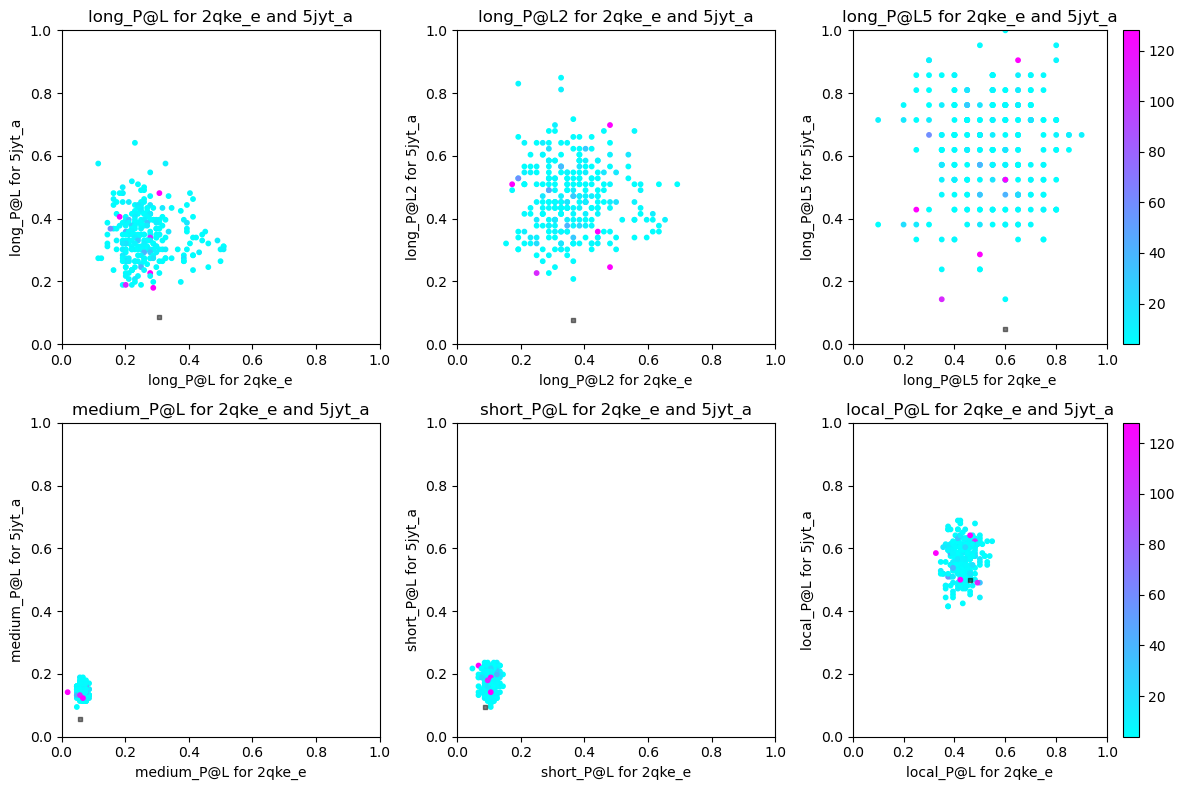

In [71]:
display_contact_results(msa_transformer_results_0, msa_transformer_results_1)

In [7]:
for i, (name, inputs) in enumerate(msas.items()):
    if i == 5:
        print(i, name)
        break
    
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    print(inputs[0])

('101', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE')
('101', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE')
('101', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE')
('101', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE')
('101', 'MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE')
5 ../AFcluster/msa_clusters/2qke_e/EX_225.a3m
